In [0]:
crime_2010 = spark.read.csv("dbfs:/FileStore/project/Crime_Data_from_2010_to_2019.csv", header=True, inferSchema=True)
crime_2020 = spark.read.csv("dbfs:/FileStore/project/Crime_Data_from_2020_to_Present.csv", header=True, inferSchema=True)
arrest_2010 = spark.read.csv("dbfs:/FileStore/project/Arrest_Data_from_2010_to_2019.csv", header=True, inferSchema=True)
arrest_2020 = spark.read.csv("dbfs:/FileStore/project/Arrest_Data_from_2020_to_Present.csv", header=True, inferSchema=True)

In [0]:
from pyspark.sql.functions import col, year, month, to_date, dayofweek, to_timestamp
crime_2010 = crime_2010.withColumnRenamed("AREA ", "AREA")
crime_2010 = crime_2010.withColumn("DATE OCC", to_timestamp(col("DATE OCC"), "MM/dd/yyyy hh:mm:ss a"))
crime_2020 = crime_2020.withColumn("DATE OCC", to_timestamp(col("DATE OCC"), "MM/dd/yyyy hh:mm:ss a"))


In [0]:
# Merge Crime Data
crime_all = crime_2010.unionByName(crime_2020)

# Extract Features
crime_all = crime_all.withColumn("Year", year("DATE OCC"))
crime_all = crime_all.withColumn("Month", month("DATE OCC"))
crime_all = crime_all.withColumn("Weekday", dayofweek("DATE OCC"))

# Top 10 Crimes
top_crimes = crime_all.groupBy("Crm Cd Desc").count().orderBy(col("count").desc())
top_crimes.show(10)

+--------------------+------+
|         Crm Cd Desc| count|
+--------------------+------+
|    VEHICLE - STOLEN|276132|
|BATTERY - SIMPLE ...|265931|
|BURGLARY FROM VEH...|226774|
|            BURGLARY|206349|
|THEFT PLAIN - PET...|204143|
|   THEFT OF IDENTITY|193209|
|VANDALISM - FELON...|171222|
|INTIMATE PARTNER ...|161378|
|ASSAULT WITH DEAD...|146722|
|THEFT FROM MOTOR ...|130536|
+--------------------+------+
only showing top 10 rows



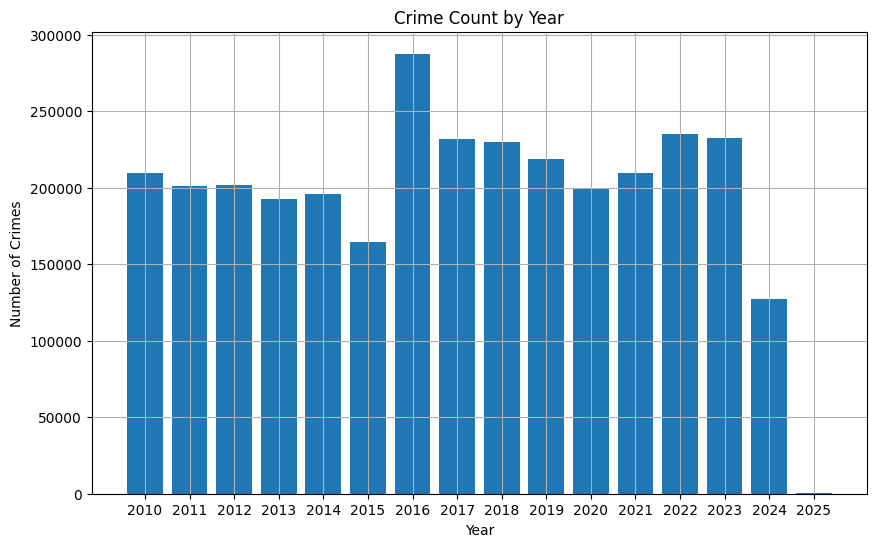

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
# Crime Trend by Year
yearly_trend = crime_all.groupBy("Year").count().orderBy("Year")

# Convert to Pandas for Plotting
yearly_pd = yearly_trend.toPandas()
plt.figure(figsize=(10,6))
plt.bar(yearly_pd["Year"].astype(str), yearly_pd["count"])
plt.title("Crime Count by Year")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.grid(True)
plt.show()



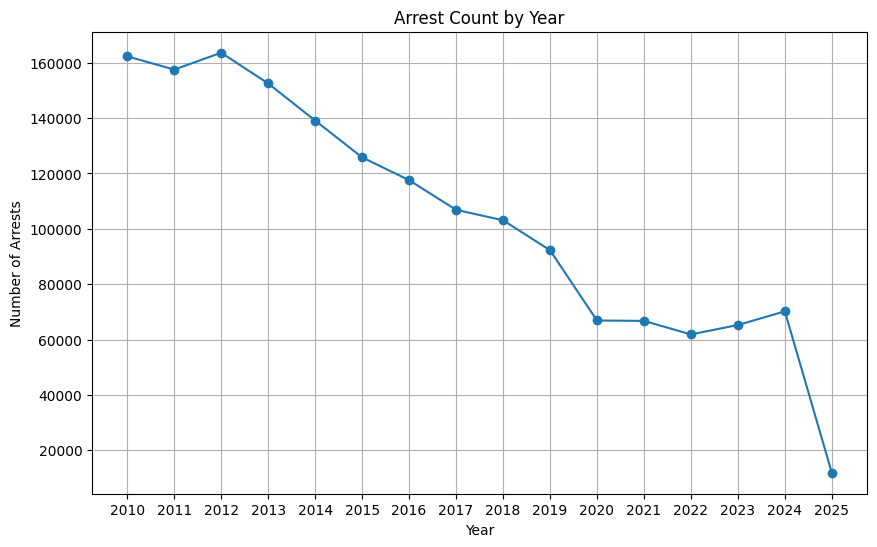

+-----------+------+
|  Area Name| count|
+-----------+------+
|    Central|158442|
|  Hollywood|142094|
|    Pacific|123780|
|77th Street| 95996|
|    Rampart| 95319|
|     Newton| 90070|
|  Southwest| 89005|
|   Van Nuys| 87918|
|    Mission| 82153|
|N Hollywood| 81749|
+-----------+------+
only showing top 10 rows

+----+-----------+------------+
|AREA|Crime Count|Arrest Count|
+----+-----------+------------+
|  12|     207567|       95996|
|   3|     193343|       89005|
|  14|     172320|      123780|
|   1|     168167|      158442|
|  15|     165408|       81749|
|  18|     162179|       66190|
|   6|     151759|      142094|
|  13|     149539|       90070|
|  20|     146534|       67313|
|  17|     145727|       53021|
|  19|     144826|       82153|
|  11|     143511|       62794|
|   9|     143010|       87918|
|  21|     140471|       58748|
|   7|     137161|       41986|
|   2|     136760|       95319|
|   8|     134966|       40164|
|   5|     133675|       59054|
|  10|  

In [0]:
# Merge Arrest Data
arrest_2010 = arrest_2010.withColumnRenamed("Area ID", "AREA")
arrest_2020 = arrest_2020.withColumnRenamed("Area ID", "AREA")
arrest_all = arrest_2010.unionByName(arrest_2020)

# Parse Dates
arrest_2010 = arrest_2010.withColumn("Arrest Date", to_timestamp(col("Arrest Date"), "MM/dd/yyyy"))
arrest_2020 = arrest_2020.withColumn("Arrest Date", to_timestamp(col("Arrest Date"), "MM/dd/yyyy hh:mm:ss a"))
arrest_all = arrest_2010.unionByName(arrest_2020)

# Extract Year
arrest_all = arrest_all.withColumn("Year", year("Arrest Date"))

# Arrest Count by Year
arrest_yearly = arrest_all.groupBy("Year").count().orderBy("Year")
arrest_pd = arrest_yearly.toPandas()
plt.figure(figsize=(10,6))
plt.plot(arrest_pd["Year"].astype(str), arrest_pd["count"], marker='o')
plt.title("Arrest Count by Year")
plt.xlabel("Year")
plt.ylabel("Number of Arrests")
plt.grid(True)
plt.show()

# Arrests by Area
arrest_area = arrest_all.groupBy("Area Name").count().orderBy(col("count").desc())
arrest_area.show(10)

# Optional: Join crime and arrest data by AREA for correlation (basic)
crime_by_area = crime_all.groupBy("AREA").count().withColumnRenamed("count", "Crime Count")
arrest_by_area = arrest_all.groupBy("AREA").count().withColumnRenamed("count", "Arrest Count")
area_merged = crime_by_area.join(arrest_by_area, on="AREA", how="inner")
area_merged.orderBy(col("Crime Count").desc()).show()
